In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import toml

from modules.plot import merge_line_legends
from modules.utils import load, expected_indepencent_jaccard
from tasks.totaling import TotalizeValid

sns.set()
sns.set_style('ticks')

TensorFlow version 1.15.3 has been patched using tfdeterminism version 0.3.0


In [2]:
# output dir
out_dir = './results'
os.makedirs(out_dir, exist_ok=True)

In [3]:
# visual settings
evalmetrics = [
    'tau',
    'jaccard'
]

d_evalmetric_ylabel = {
    'tau': "Kendal's Tau",
    'jaccard': "Jaccard index"
}

metrics = [
    'log_likelihood_kde',
    'log_inception_score',
    'fid',
]

d_metric_rename = dict((
    ('log_likelihood_kde', 'Influence on ALL'),
    ('log_inception_score', 'Influence on IS'),
    ('fid', 'Influence on FID'),
))

d_metric_color = dict((
    ('log_likelihood_kde', 'C2'),
    ('log_inception_score', 'C1'),
    ('fid', 'C0'),
))

d_metric_marker = dict((
    ('log_likelihood_kde', 's'),
    ('log_inception_score', 'D'),
    ('fid', 'o'),
))

In [4]:
# load config and pickled results
# these results can be loaded only after finishing the experiment command written in "Experiment 1: Estimation Accuracy" of README.md
conf_2d = toml.load(open('conf/2d_valid.toml', 'r'))
conf_mnist = toml.load(open('conf/mnist_valid.toml', 'r'))
task_2d = TotalizeValid(**conf_2d[TotalizeValid.__name__])
task_mnist = TotalizeValid(**conf_mnist[TotalizeValid.__name__])

dir_2d = task_2d.output().path
dir_mnist = task_mnist.output().path

d_metric_means = {
    'tau': dict((
        ('log_likelihood_kde', load(os.path.join(dir_2d, 'means_tau_log_likelihood_kde.pkl'))),
        ('log_inception_score', load(os.path.join(dir_mnist, 'means_tau_log_inception_score.pkl'))),
        ('fid', load(os.path.join(dir_mnist, 'means_tau_fid.pkl')))
    )),
    'jaccard': dict((
        ('log_likelihood_kde', load(os.path.join(dir_2d, 'means_jaccard_log_likelihood_kde.pkl'))),
        ('log_inception_score', load(os.path.join(dir_mnist, 'means_jaccard_log_inception_score.pkl'))),
        ('fid', load(os.path.join(dir_mnist, 'means_jaccard_fid.pkl')))
    ))
}

d_metric_stds = {
    'tau': dict((
        ('log_likelihood_kde', load(os.path.join(dir_2d, 'stds_tau_log_likelihood_kde.pkl'))),
        ('log_inception_score', load(os.path.join(dir_mnist, 'stds_tau_log_inception_score.pkl'))),
        ('fid', load(os.path.join(dir_mnist, 'stds_tau_fid.pkl')))
    )),
    'jaccard': dict((
        ('log_likelihood_kde', load(os.path.join(dir_2d, 'stds_jaccard_log_likelihood_kde.pkl'))),
        ('log_inception_score', load(os.path.join(dir_mnist, 'stds_jaccard_log_inception_score.pkl'))),
        ('fid', load(os.path.join(dir_mnist, 'stds_jaccard_fid.pkl')))
    ))
}

assert conf_mnist['TotalizeValid']['retrace_afters'] == conf_2d['TotalizeValid']['retrace_afters']
retrace_afters = np.asarray(conf_2d['TotalizeValid']['retrace_afters'])

assert conf_mnist['TotalizeValid']['nepochs'] == conf_2d['TotalizeValid']['nepochs']
nepoch = conf_2d['TotalizeValid']['nepochs']

assert conf_mnist['TotalizeValid']['ncfsgd'] == conf_2d['TotalizeValid']['ncfsgd']
nsamp_target = conf_2d['TotalizeValid']['ncfsgd']

assert conf_mnist['TotalizeValid']['jaccard_size'] == conf_2d['TotalizeValid']['jaccard_size']
jaccard_size = int(conf_2d['TotalizeValid']['jaccard_size'] * nsamp_target)

d_metric_random = {
    'tau': 0,
    'jaccard': expected_indepencent_jaccard(nsamp_target, jaccard_size)
}

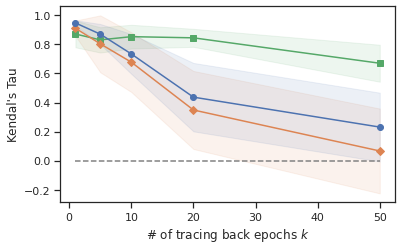

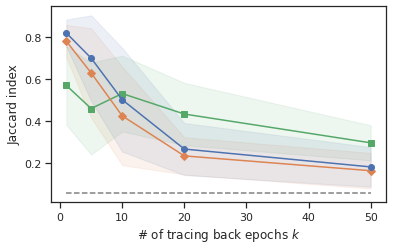

In [5]:
figs = []
for evalmetric in evalmetrics:
    fig, ax = plt.subplots(figsize=(6, 4))
    ks = nepoch - np.asarray(retrace_afters)

    for metric, mean, std in zip(d_metric_means[evalmetric].keys(), d_metric_means[evalmetric].values(),
                                 d_metric_stds[evalmetric].values()):
        ax.plot(ks, mean, label=d_metric_rename[metric], marker=d_metric_marker[metric], color=d_metric_color[metric])
        ax.fill_between(ks, mean - std, mean + std, alpha=.1, color=d_metric_color[metric])
    ax.plot(ks, np.ones_like(retrace_afters) * d_metric_random[evalmetric], '--', color='grey', label='Random')
    ax.set_xlabel('# of tracing back epochs $\it{k}$')
    ax.set_ylabel(d_evalmetric_ylabel[evalmetric])

    fig.subplots_adjust(bottom=0.2)
    fig.savefig(os.path.join(out_dir, f'{evalmetric}_valid.pdf'))
    figs.append(fig)


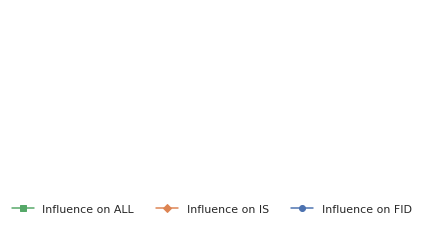

In [6]:
# collect lines to make one legend figure
merge_line_legends(
    figs=figs,
    line_names=[d_metric_rename[x] for x in metrics],
    out_path=os.path.join(out_dir, 'legend_valid.pdf'),
    ncol=4
)